In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import sys
import math
from datetime import datetime
#import relu
from torch.nn import functional as F
sys.path.append('../models')
sys.path.append('../data_func')
from data_helper_functions import create_study_periods,create_tensors
from transformer_model import TimeSeriesTransformer,ScaledMultiHeadAttention

We can train multiple transformer models. 1. Cross-sectional-Median Target 2. Raw-returns target 3. Sharpe ratio objective 4. Selective Transformer Model with all of the previous iterations. We can also consider Stochastic Attention, using Attention to calculate a confidence score, and building a confidence model as a first pass. (Cross-sectional median confidence as first filter, and then use the confidence score to select the top 10% of stocks to train on.)
All in all, because of compute the goal shouldn't be to train a model that generates an insane sharpe, but show the potential of Selective ML in portfolio building and how it improves over current SOTA methods. The paper should mostly be an analysis on what types of stocks the model does not learn from/ abstains from.  We can't afford to hyper-parameter tune a lot.

In [14]:
# df=pd.read_csv('../data/crsp_ff_adjusted.csv')
# #drop unamed 0
# df['date'] = pd.to_datetime(df['date'])
# df.dropna(subset=['RET'],inplace=True)
# df=df.drop(columns='Unnamed: 0')
# df 

In [15]:
# #get just 2014
# df=df[df['date'].dt.year==2014]

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(42)  # for reproducibility

def generate_individual_stock_data(num_days=1000, pattern='sine', start_price=100):
    if pattern == 'random':
        price_changes = np.random.randn(num_days) * 0.5 + 0.1  # daily returns
        prices = np.cumsum(price_changes) + start_price  # price series
    elif pattern == 'sine':
        x = np.linspace(0, 20, num_days)
        prices = np.sin(x) * 10 + start_price
    elif pattern == 'exponential':
        x = np.linspace(0, 5, num_days)
        prices = np.exp(x) + start_price

    return prices

def process_stock_data(prices, sequence_length=250):
    log_returns = np.log(prices[1:] / prices[:-1])
    data = []
    labels = []
    for i in range(len(log_returns) - sequence_length):
        data.append(log_returns[i:i + sequence_length])
        labels.append(log_returns[i + sequence_length])
    return np.array(data), np.array(labels)

# Set parameters
num_days = 1000
sequence_length = 250
train_period = 750

# Patterns
patterns = ['random', 'sine', 'exponential']

# Generate data for each pattern
stocks_data = []
for pattern in patterns:
    prices = generate_individual_stock_data(num_days=num_days, pattern=pattern, start_price=100)
    stock_data, stock_labels = process_stock_data(prices, sequence_length=sequence_length)
    stocks_data.append((stock_data[:train_period], stock_labels[:train_period],
                        stock_data[train_period-sequence_length:],
                        stock_labels[train_period-sequence_length:]))

# Prepare the final datasets
train_data_combined = np.concatenate([data[0] for data in stocks_data], axis=0)
train_labels_combined = np.concatenate([data[1] for data in stocks_data], axis=0)
test_data_combined = np.concatenate([data[2] for data in stocks_data], axis=0)
test_labels_combined = np.concatenate([data[3] for data in stocks_data], axis=0)

# Convert to tensors
train_data_tensor = torch.tensor(train_data_combined, dtype=torch.float32).unsqueeze(-1)
train_labels_tensor = torch.tensor(train_labels_combined, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data_combined, dtype=torch.float32).unsqueeze(-1)
test_labels_tensor = torch.tensor(test_labels_combined, dtype=torch.float32)

train_test_splits = [(train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor)]



In [17]:
#Optional parameter target_type: 'cross_sectional_median(default)','buckets(10 buckets)','raw_returns'.
# study_periods=create_study_periods(df,n_periods=23,window_size=240,trade_size=250,train_size=750,forward_roll=250,start_date=datetime(1990,1,1),end_date=datetime(2015,12,31),target_type='raw_return')

In [18]:
# train_test_splits,task_types=create_tensors(study_periods)

In [19]:
#Optional code to verify tensor shapes
# for train_data, train_labels, test_data, test_labels in train_test_splits:
#     print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

In [20]:
task_types=['regression']

In [21]:
#LOOK INTO MAKING THE D_MODEL>1 YOU'LL HAVE TO STACK INPUTS AS CURRENT INPUT IS [BATCH,SEQUENCE,1] NOT [BATCH,SEQUENCE,D_MODEL]

#ALSO FIX BATCH SIZE ERROR

In [22]:
# Check if CUDA, MPS, or CPU should be used
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)
best_model_path = "best_model.pth" 
model = TimeSeriesTransformer(d_model=16, num_heads=2, d_ff=4, num_encoder_layers=1, 
                               dropout=.1,task_type=task_types[0]).to(device)

# Loss depends on target, MAE for returns, Cross Entropy for above/below cross-sectional median. Also have selective loss in utils
if task_types[0] == 'classification':
    criterion = nn.NLLLoss()
else:
    criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
patience = 5
best_loss = np.inf
counter = 0
batch_size=64
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    for train_data, train_labels, val_data, val_labels in tqdm(train_test_splits):
        train_dataset = TensorDataset(train_data, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = TensorDataset(val_data, val_labels)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        #reshape to batch,sequence,d_model
        
        # Access the batch size from the train_loader
        batch_size = train_loader.batch_size
        sequence_length = train_loader.dataset.tensors[0].size(1)

        train_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            train_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=data.size(0), sequence_length=data.size(1))
            
            optimizer.zero_grad()
            outputs = model(data, src_mask=train_mask).squeeze()
            if task_types[0] == 'classification':
                labels = labels.long()  # Adjusted here to use the look-ahead mask
            loss = criterion(outputs, labels)  # Adjust based on your specific use case
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

        total_train_loss += train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                val_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=data.size(0), sequence_length=data.size(1))

                outputs = model(data, src_mask=val_mask).squeeze()
                if task_types[0] == 'classification':
                    labels = labels.long() # Adjusted here to use the look-ahead mask
                loss = criterion(outputs, labels)  # Adjust based on your specific use case
                val_loss += loss.item() * data.size(0)

        total_val_loss += val_loss / len(val_loader.dataset)

    average_train_loss = total_train_loss / len(train_test_splits)
    average_val_loss = total_val_loss / len(train_test_splits)
    
    print(f'Epoch {epoch+1}/{n_epochs}, '
          f'Average Train Loss: {average_train_loss:.4f}, '
          f'Average Validation Loss: {average_val_loss:.4f}')

    if average_val_loss < best_loss:
        best_loss = average_val_loss
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1

    if counter == patience:
        print('Early stopping!')
        break

best_model_state = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_model_state)

Using device: cpu


100%|██████████| 1/1 [00:18<00:00, 18.93s/it]


Epoch 1/100, Average Train Loss: 0.0313, Average Validation Loss: 0.0014


100%|██████████| 1/1 [00:21<00:00, 21.79s/it]


Epoch 2/100, Average Train Loss: 0.0059, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:18<00:00, 18.47s/it]


Epoch 3/100, Average Train Loss: 0.0027, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


Epoch 4/100, Average Train Loss: 0.0017, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:21<00:00, 21.01s/it]


Epoch 5/100, Average Train Loss: 0.0014, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:18<00:00, 18.36s/it]


Epoch 6/100, Average Train Loss: 0.0012, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


Epoch 7/100, Average Train Loss: 0.0011, Average Validation Loss: 0.0000


100%|██████████| 1/1 [00:18<00:00, 18.06s/it]

Epoch 8/100, Average Train Loss: 0.0009, Average Validation Loss: 0.0000
Early stopping!


<All keys matched successfully>

Mean Squared Error: 4.96790926263202e-06


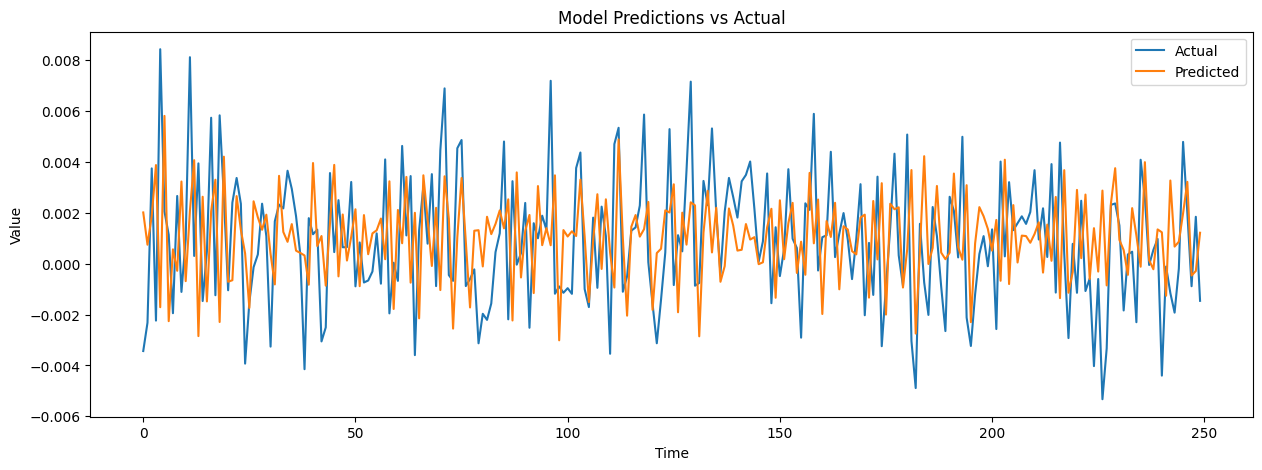

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import numpy as np

# Assuming your model is for regression. Change this part if it's for classification.
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(actuals)

# Create DataLoader for test data
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Calculate performance metrics
if model.task_type == 'regression':
    mse = mean_squared_error(actuals, predictions)
    print(f'Mean Squared Error: {mse}')
    # Can also calculate RMSE, MAE, etc.
elif model.task_type == 'classification':
    accuracy = accuracy_score(actuals, predictions.round())
    print(f'Accuracy: {accuracy}')
    print(classification_report(actuals, predictions.round()))

# Plotting predictions vs actuals for a subset of the test data
plt.figure(figsize=(15, 5))
plt.plot(actuals[:250], label='Actual')
plt.plot(predictions[:250], label='Predicted')
plt.title('Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TimeSeriesTransformer(d_model=64, num_heads=8, d_ff=256, num_encoder_layers=2, 
#                                dropout=.1, max_len=240,task_type='classification')
model.load_state_dict(torch.load('best_model.pth',map_location=torch.device('cpu')) )
model.eval()

in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

k = 10  # Number of top assets to select in portfolios

for train_data, train_labels, val_data, val_labels in tqdm(train_test_splits):
    # Here, train_data, val_data are your training and validation data respectively
    

    train_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=train_data.size(0), sequence_length=train_data.size(1))
    val_mask = ScaledMultiHeadAttention.create_look_ahead_mask(batch_size=val_data.size(0), sequence_length=val_data.size(1))

    with torch.no_grad():
        train_predictions = model(train_data.to(device), src_mask=train_mask.to(device))
        val_predictions = model(val_data.to(device), src_mask=val_mask.to(device))

        train_probs = torch.softmax(train_predictions, dim=1)[:, 1].cpu().numpy()
        val_probs = torch.softmax(val_predictions, dim=1)[:, 1].cpu().numpy()

    # Assuming you have a dataframe or similar structure to hold the date and TICKER information
    train_df['predicted_prob'] = train_probs
    val_df['predicted_prob'] = val_probs

    # In-Sample Portfolio Construction
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date].sort_values(by='predicted_prob', ascending=False)
        
        long_tickers = date_data.head(k)
        short_tickers = date_data.tail(k)
        
        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Out-of-Sample Portfolio Construction
    for date in val_df['date'].unique():
        date_data = val_df[val_df['date'] == date].sort_values(by='predicted_prob', ascending=False)
        
        long_tickers = date_data.head(k)
        short_tickers = date_data.tail(k)
        
        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])

# At this point, in_sample_long_portfolios, out_of_sample_long_portfolios, etc. hold your portfolios



  0%|          | 0/1 [00:00<?, ?it/s]

: 

In [ ]:
in_sample_long_portfolios.to_csv('../data/transformer_results/in_sample_long_portfolios.csv')
in_sample_short_portfolios.to_csv('../data/transformer_results/in_sample_short_portfolios.csv')
out_of_sample_long_portfolios.to_csv('../data/transformer_results/out_of_sample_long_portfolios.csv')
out_of_sample_short_portfolios.to_csv('../data/transformer_results/out_of_sample_short_portfolios.csv')